In [1]:
import moderngl as mgl
from pathlib import Path
import numpy as np
from PIL import Image
import glm
import re

In [2]:
# If ctx is already defined, do nothing
try:
    ctx
except NameError:
    ctx = mgl.create_context(standalone=True)
ctx.gc_mode = 'auto'
ctx.enable(mgl.DEPTH_TEST | mgl.CULL_FACE | mgl.BLEND)

In [3]:
resolution = (512, 512)
msaa = 4
fbo = ctx.simple_framebuffer((resolution[0] * msaa, resolution[1] * msaa))
def show(fbo):
    img = Image.frombytes('RGB', fbo.size, fbo.read(), 'raw', 'RGB', 0, -1)
    img = img.reduce(msaa)
    return img

In [4]:
# Color Wheel test

vert_src = Path('./shaders/color_wheel.vert').read_text()
frag_src = Path('./shaders/color_wheel.frag').read_text()
prog = ctx.program(vertex_shader=vert_src, fragment_shader=frag_src)

In [5]:
prog['screenSize'] = fbo.size
verts = np.array([
    -1, 1,
    -1, -1,
    1, -1,
    1, 1,
    -1, 1,
    1, -1,
])
vbo = ctx.buffer(verts.astype('f4').tobytes())
vao = ctx.vertex_array(prog, vbo, 'iPos')

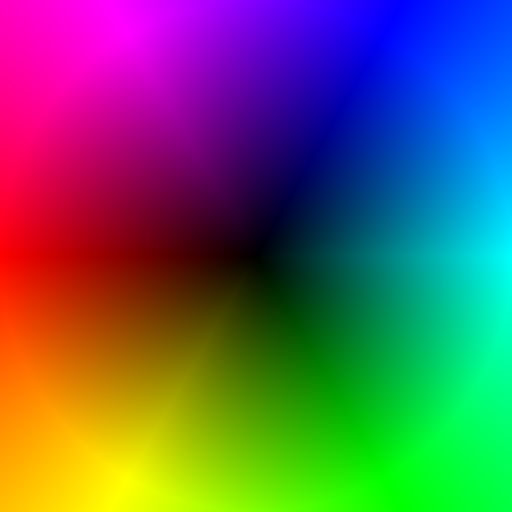

In [6]:
fbo.use()
fbo.clear(0.0, 0.0, 0.0, 1.0)
vao.render()
show(fbo)

In [7]:
verts = []
norms = []
tris = []
filename = './models/teapot.obj'
with open(filename) as teapot:
    for line in teapot:
        args = re.split(' +', line)
        match args[0]:
            case 'v':
                verts.append([float(x) for x in args[1:4]])
            case 'vn':
                norms.append([float(x) for x in args[1:4]])
            case 'f':
                idx = []
                for arg in args[1:4]:
                    nums = arg.split('/')
                    idx.append([int(nums[0]), int(nums[2])])
                tris.append([int(x.split('/')[0]) - 1 for x in args[1:4]])
print(f'Loaded {filename}: {len(verts)} verts, {len(norms)} normals, {len(tris)} tris')
verts = np.array(verts)
norms = np.array(norms)
tris = np.array(tris)

Loaded ./models/teapot.obj: 530 verts, 530 normals, 992 tris


In [8]:
vert_src = Path('./shaders/vertex.glsl').read_text()
frag_src = Path('./shaders/frag.glsl').read_text()
prog = ctx.program(vertex_shader=vert_src, fragment_shader=frag_src)

In [9]:
vbo = ctx.buffer(verts.astype('f4').tobytes())
nbo = ctx.buffer(norms.astype('f4').tobytes())
ibo = ctx.buffer(tris.astype('i2').tobytes())
vao = ctx.vertex_array(prog, [
        (vbo, '3f', 'iPos'),
        (nbo, '3f', 'iNorm'),
    ],
    index_buffer=ibo,
    index_element_size=2
)

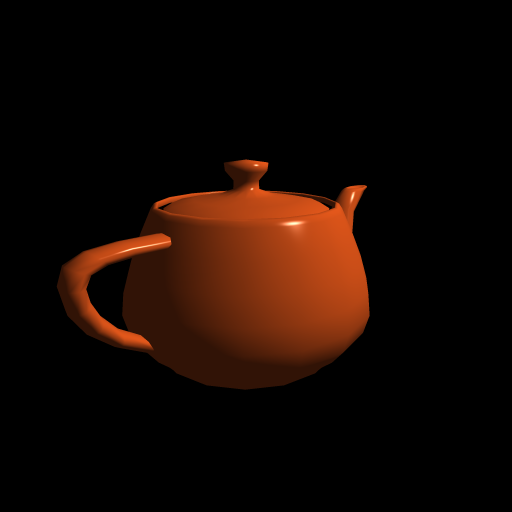

In [10]:
model = glm.mat4(1)
view = glm.lookAt((-25, 10, 25), (0, 0, 0), (0, 1, 0))
proj = glm.perspective(np.deg2rad(60), 1, 0.1, 100.0)
modelView = view * model
modelViewN = view * glm.transpose(glm.inverse(model))

prog['lightPos'] = 50, 50, 0
prog['lightAmb'] = 1, 1, 1
prog['lightDiff'] = 1, 1, 1
prog['lightSpec'] = 1, 1, 1
prog['matAmb'] = 0.19125, 0.0735, 0.0225
prog['matDiff'] = 0.7038, 0.27048, 0.0828
prog['matSpec'] = 0.774597, 0.774597, 0.774597
prog['matShine'] = 0.6 * 128
prog['modelView'].write(modelView.to_bytes())
prog['modelViewN'].write(modelViewN.to_bytes())
prog['proj'].write(proj.to_bytes())

fbo.use()
fbo.clear(0, 0, 0, 1)
vao.render()
show(fbo)